Importing necessary libraries

In [1]:
# for display purposes, we hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
import nltk
import pycountry
from sklearn.feature_extraction.text import CountVectorizer
import requests
import json
import nltk.sentiment
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import utils_2 as u
from matplotlib import cm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def isolate_line(s, n, marker):
    start = s[:n].rfind(marker) + len(marker)
    if start < 0:
        start = 0
    sub_s = s[start:]
    end = sub_s.find(marker)
    if end < 0:
        end = len(s)
    final = sub_s[:end]
    return final

# Sentiment analysis by country
## Preliminaries


### Getting and preparing the email corpus
Here we will find mentions of countries in Hillary Clinton's emails and try to assess the sentiment expressed by using sentiment analysis techniques.

In [3]:
emails = pd.read_csv('./hillary-clinton-emails/Emails.csv')
emails.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...


As in exercise 1, we run our cleaning pipeline on the emails.

In [4]:
# concat all the emails into one string
from cleaner import *

# initiate Cleaner class
cleaner = Cleaner()
clean_text_series = cleaner.cleaning_pipeline_series(emails.ExtractedBodyText.dropna())

In [5]:
df = pd.DataFrame({'Text':clean_text_series})
df.head()

,Text
1,"[thursday, march, 2011, latest, syria, aid, qa..."
2,[thx]
4,"[friday, march, 2011, huma, abedin, latest, sy..."
5,"[pi, print, wednesday, septemb, 2012, russorv,..."
7,"[friday, march, 2011, huma, abedin, latest, sy..."


### Creating a dictionnary of countries

We create a dictionnary containing different names for each country. We use an API to go and look for the country's capital city as well, as we believe that if there is a sentiment about a capital city, it also expresses a sentiment about the country.

In [6]:
countries = {}

bullshit_countries = ["Antarctica"]

for country in pycountry.countries:
    if country.name not in bullshit_countries:
        list_to_search = []
        list_to_search.append(country.name.split(",")[0].lower())
        # commenting out alpha_2 makes life easier, e.g. NO for Norway is misleading
        #list_to_search.append(country.alpha_2)
        # typical alpha_3 problem
        if country.alpha_3 != 'AND':
            list_to_search.append(country.alpha_3)
        
        # getting the country's capital city's name
        try:
            str_text = requests.get("https://restcountries.eu/rest/v1/alpha/" + country.alpha_2.lower()).text
            dic = json.loads(str_text)
            list_to_search.append(dic["capital"].lower())
        except:
            print(str_text)
            pass

        # introducing some custom terms
        if country.name == "Syrian Arab Republic":
            list_to_search.append("syria")
        if country.name == "Russian Federation":
            list_to_search.append("russia")
        countries[country.name] = list_to_search

We introduce some custom adjustments

In [7]:
countries["UK"] = ['uk', 'united kingdom', 'great britain']
countries["United States"].append("U.S.")
countries["United States"].append("U.S.A.")

## Running the sentiment analysis

### VADER sentiment analysis tool

We first use the Vader method. To use it properly, we rewrote it to modify its output, as you can see in _utils.py_.

Then, for every email, we check every country to see if it is mentioned in the body of the email. If it is the case, we use our function `isolate_line()` to consider only the sentence mentioning the country.

Why consider only specific sentences? We believe they carry a more precise sentiment about the country and are easier to analyse. What's more, this takes care at least partly of the problem of emails mentioning several countries.

All this is written in the `sentiment_process()` function in _utils.py_.

In [8]:
vader_result = u.sentiment_process(emails, countries, 'vader')

We then store the results in a data frame to process them.

In [9]:
def make_frame(key, value):
    n_mention = int(len(value['mention']))
    pos = sum(value['pos'])/float(len(value['pos']))
    neg = sum(value['neg'])/float(len(value['neg']))
    df = pd.DataFrame([[key, n_mention, pos, neg]], columns=['country', 'n_mention', 'pos', 'neg'])
    return df

In [10]:
vader_frame = pd.DataFrame(columns=['country', 'n_mention', 'pos', 'neg'])
for key, value in vader_result.items():
    df = make_frame(key, value)
    vader_frame = vader_frame.append(df, ignore_index=True)

In [13]:
vader_frame.head(2)

,country,n_mention,pos,neg,polarity
0,Libya,188.0,0.087277,0.094729,-0.007452
1,Bahamas,2.0,0.188500,0.037000,0.151500


Then, we define the polarity level as the difference between the positive and negative score obtained with the Vader method.

In [14]:
vader_frame['polarity'] = vader_frame.pos-vader_frame.neg

We restrict our results to countries that have more than 20 mentions. As the scores are averaged over the number of mentions, we think that countries with few mentions might suffer from higher scoring mistakes. We thus lose a lot of countries, but having less countries also makes the graphs nicer.

In [19]:
vader_frame_20 = vader_frame.loc[vader_frame.n_mention > 20]

In [20]:
print('all: '+str(vader_frame.shape))
print('>20: '+str(vader_frame_20.shape))

all: (135, 5)
>20: (39, 5)


We sort the data by _polarity_.

In [21]:
vader_frame_20 = vader_frame_20.sort_values(by='polarity')

And then we show a bar plot where the (negative or positive) height represents the polarity level of a country and the color of the bar gets darker the more times it is mentioned.

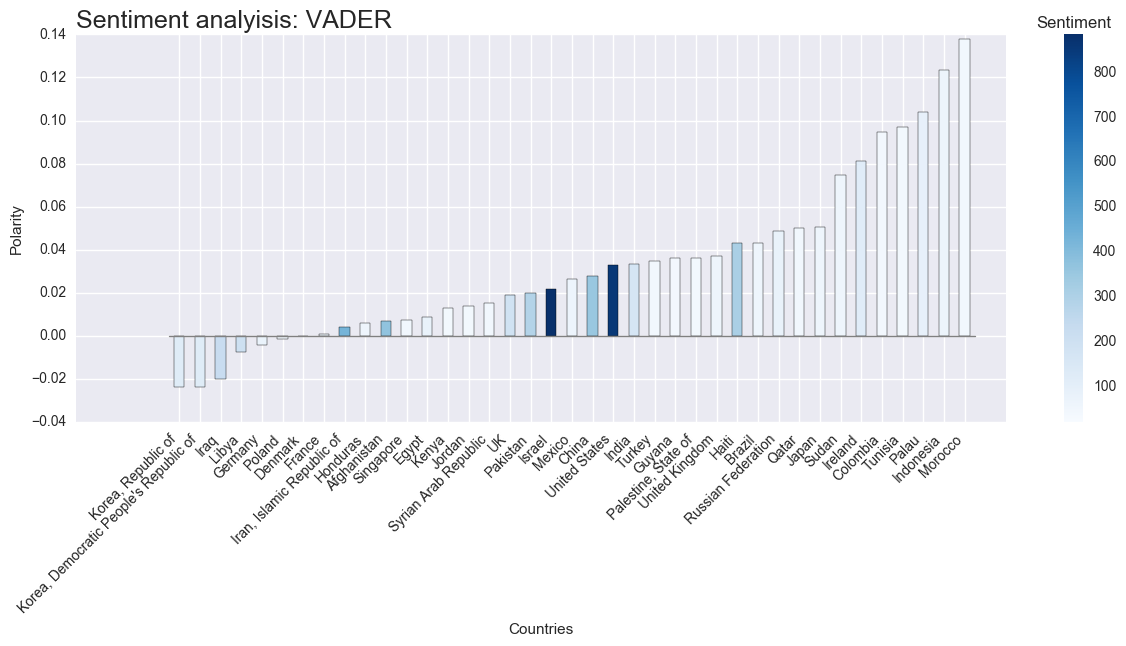

In [22]:
polarity = vader_frame_20.polarity.values
countries_graph = vader_frame_20.country.values
n_mention = vader_frame_20.n_mention.values

u.plot_frame(polarity, countries_graph, n_mention, 'Sentiment analyisis: VADER')

We know little about geopolitics, but there seem to be some weird results in this graph. Very few countries are listed as viewed negatively and there some unexpected countries show up positively, such as the _Syrian Arab Republic_.

### Liu and Hu opinion lexicon

We now repeat the process using Liu and Hu opinion lexicon. As the process is very slow, we ran it once and saved its results in a json file. It can be run calling `u.sentiment_process(emails, countries, 'liu')`.

In [23]:
with open('assets/liu.json') as data_file:    
    liu = json.load(data_file)

We tweaked the _Liu and Hu_ method so that it returns 1, -1 or 0 if the sentiment is positive, negative or neutral. For every mention of a country, we add the new value so that in the end the sentiment of a country is the sum of its _Liu and Hu_ values. We then normalize it by dividing by the number of mentions.

In [24]:
def make_frame_liu(key, value):
    n_mention = int(len(value['mention']))
    senti = value['sentiment']/n_mention
    df = pd.DataFrame([[key, n_mention, senti]], columns=['country', 'n_mention', 'sentiment'])
    return df

In [25]:
liu_frame = pd.DataFrame(columns=['country', 'n_mention', 'sentiment'])
for key, value in liu.items():
    df = make_frame_liu(key, value)
    liu_frame = liu_frame.append(df, ignore_index=True)

Restricting and sorting:

In [ ]:
liu_frame_20 = liu_frame.sort_values(by='polarity').loc[liu_frame.n_mention > 20]

We make the same plot as before, with the _Liu and Hu_ results

In [26]:
polarity = liu_frame_20.sentiment.values
countries = liu_frame_20.country.values
n_mention = liu_frame_20.n_mention.values

u.plot_frame(polarity, countries, n_mention, 'Sentiment analysis: Liu and Hu')

NameError: name 'liu_frame_20' is not defined

## Conclusion

We can see substantial differences between the two methods. The second graph shows more countries are considered as associated with negative sentiment. Perhaps most surprisingly, Israel is seen here in a negative light although the VADER method showed a positive sentiment about it.

These differences cast doubts about the immediate validity of such methods. To make a proper assessment of sentiments in these emails would require a lot more work, in deeper detail.